In [1]:
import os
import tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.2


In [2]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

In [4]:
bdata = sc.read_h5ad('h5ad/df.fil3_gex_bcells_vdj.h5ad')
bdata

AnnData object with n_obs × n_vars = 75683 × 385
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [5]:
pd.crosstab(bdata.obs['celltype_B'], bdata.obs['isotype_summary'])

isotype_summary,IgA,IgD,IgD|IgM,IgE,IgG,IgM,Multi,No_contig,unassigned
celltype_B,,,,,,,,,
B_ASC_IgA,2429,27,0,1,31,139,1,953,2
B_ASC_IgG,46,3,0,0,1311,3,0,876,0
B_ASC_IgM,102,6,0,0,4,373,0,247,0
B_ASC_dividing,727,6,0,0,683,222,1,684,2
B_CD11c,268,115,3,0,485,548,1,1176,51
B_naive,61,2491,211,0,160,23818,33,11468,179
B_non-switched_mem,42,52,2,0,74,537,2,1109,22
B_switched_mem,3015,198,14,0,4107,7430,9,8598,525


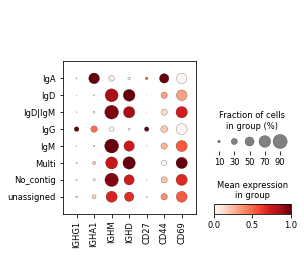

In [37]:
sc.pl.dotplot(bdata[bdata.obs['celltype_B'] == 'B_naive'], ['IGHG1', 'IGHA1', 'IGHM', 'IGHD', 'CD27', 'CD44', 'CD69'], 
              groupby = 'isotype_summary', 
              standard_scale = 'var')
# switch the 'naive' B cells that are not IgM/IgD to switched memory

In [39]:
bdata.obs['celltype_B_corrected'] = bdata.obs['celltype_B'].astype('object')

In [40]:
for i in bdata.obs.index:
    iso = bdata.obs.loc[i, 'isotype_summary']
    if bdata.obs.loc[i, 'celltype_B_corrected'] == 'B_ASC_IgA':
        if iso in ['IgA', 'Multi', 'No_contig', 'unassigned']:
            continue
        if iso in ['IgE', 'IgD']:
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_other'
        if iso == 'IgM':
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgM'
        if iso == 'IgG':
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgG'
    if bdata.obs.loc[i, 'celltype_B_corrected'] == 'B_ASC_IgG':
        if iso in ['IgG', 'Multi', 'No_contig', 'unassigned']:
            continue
        if iso in ['IgE', 'IgD']:
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_other'
        if iso == 'IgM':
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgM'
        if iso == 'IgA':
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgA'
    if bdata.obs.loc[i, 'celltype_B_corrected'] == 'B_ASC_IgM':
        if iso in ['IgM', 'Multi', 'No_contig', 'unassigned']:
            continue
        if iso in ['IgE', 'IgD']:
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_other'
        if iso == 'IgG':
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgG'
        if iso == 'IgA':
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgA'
    if bdata.obs.loc[i, 'celltype_B_corrected'] == 'B_non-switched_mem':
        if iso in ['IgM', 'IgD', 'IgM|IgD', 'IgD|IgM', 'Multi', 'No_contig', 'unassigned']:
            pass
        else:
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_switched_mem'
    if bdata.obs.loc[i, 'celltype_B_corrected'] == 'B_switched_mem':
        if iso in ['IgG', 'IgA', 'Multi', 'No_contig', 'unassigned']:
            pass
        else:
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_non-switched_mem'
    if bdata.obs.loc[i, 'celltype_B_corrected'] == 'B_naive':
        if iso in ['IgM', 'IgD', 'IgM|IgD', 'IgD|IgM', 'Multi', 'No_contig', 'unassigned']:
            pass
        else:
            bdata.obs.at[i, 'celltype_B_corrected'] = 'B_switched_mem'

In [41]:
pd.crosstab(bdata.obs['celltype_B_corrected'], bdata.obs['isotype_summary'])

isotype_summary,IgA,IgD,IgD|IgM,IgE,IgG,IgM,Multi,No_contig,unassigned
celltype_B_corrected,,,,,,,,,
B_ASC_IgA,2577,0,0,0,0,0,1,953,2
B_ASC_IgG,0,0,0,0,1346,0,0,876,0
B_ASC_IgM,0,0,0,0,0,515,0,247,0
B_ASC_dividing,727,6,0,0,683,222,1,684,2
B_ASC_other,0,36,0,1,0,0,0,0,0
B_CD11c,268,115,3,0,485,548,1,1176,51
B_naive,0,2491,211,0,0,23818,33,11468,179
B_non-switched_mem,0,250,16,0,0,7967,2,1109,22
B_switched_mem,3118,0,0,0,4341,0,9,8598,525


... storing 'celltype_B_corrected' as categorical


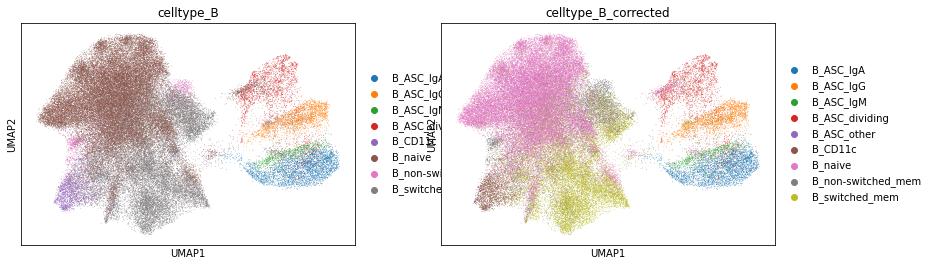

In [43]:
sc.pl.umap(bdata, color = ['celltype_B', 'celltype_B_corrected'])

In [44]:
# save
bdata.write_h5ad('h5ad/df.fil3_gex_bcells_vdj.h5ad', compression = 'gzip')

In [ ]:
# propagate to the main object

In [45]:
adata = sc.read_h5ad('h5ad/df.fil3_gex_kt.h5ad')
adata

AnnData object with n_obs × n_vars = 916806 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartm

In [47]:
adata.obs['celltype_B_corrected'] = pd.Series(bdata.obs['celltype_B_corrected'])

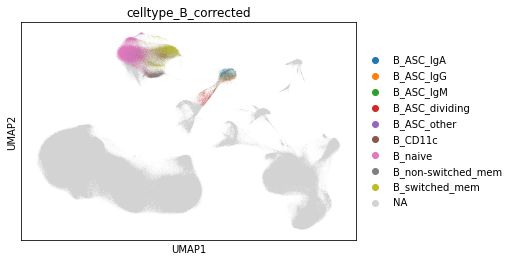

In [48]:
sc.pl.umap(adata, color = 'celltype_B_corrected')

In [49]:
adata.write_h5ad('h5ad/df.fil3_gex_kt.h5ad', compression = 'gzip')